# Imports

In [24]:
import numpy as np
import pandas as pd
import os 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from joblib import dump, load

In [25]:
df = pd.read_csv("dataset/dataset_with_predicted_mean_A_mean_V.csv")
# df.head()

In [26]:
base_url_clf = 'classifier/randomforest'

# Split dataset into inputs and targets

In [27]:
# drop target value, student annotations and string ID from input features:
X = df.drop(columns=['quadrant','mean_A','mean_V','id','score_mode','score_key_strength'])

# we want to predict the quadrant:
y = df['quadrant'].values

In [28]:
X.head()

,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,essentia_spectral_centroid_mean,essentia_spectral_centroid_stdev,essentia_spectral_complexity_mean,...,midlevel_features_melody,midlevel_features_articulation,midlevel_features_rhythm_complexity,midlevel_features_rhythm_stability,midlevel_features_dissonance,midlevel_features_tonal_stability,midlevel_features_minorness,predicted_mean_A,predicted_mean_V,predicted_quadrant
0,0.206445,0.131383,13.998791,58.329521,3.1,0.539736,0.193987,3367.790527,3684.124268,2.986095,...,0.065397,-0.029380,-0.303987,-0.053306,-0.325228,0.347745,-0.119278,45.216172,1.749838,4
1,0.145753,0.057971,3.533264,75.166183,4.2,0.476832,0.123564,1395.528809,401.987610,4.181923,...,0.353040,-0.073957,-0.381182,0.120750,-0.479266,0.451572,-0.064252,42.078254,0.360194,4
2,0.149111,0.059011,3.337368,82.753929,4.3,0.457741,0.132359,1318.759644,289.306152,4.303592,...,0.201885,0.016944,-0.337422,0.103853,-0.388214,0.430684,-0.226197,48.451175,1.963364,4
3,0.163914,0.057474,3.078172,79.024742,4.1,0.504427,0.121134,1258.258423,262.561310,5.271147,...,0.181998,-0.019165,-0.314282,0.118872,-0.335902,0.314371,-0.006619,45.000775,1.033474,4
4,0.157382,0.054116,2.682208,59.633064,3.9,0.503377,0.121658,1244.375122,260.756195,4.122828,...,0.256362,-0.151648,-0.302913,-0.002940,-0.395495,0.368037,-0.162711,31.551966,0.747443,4


<AxesSubplot:>

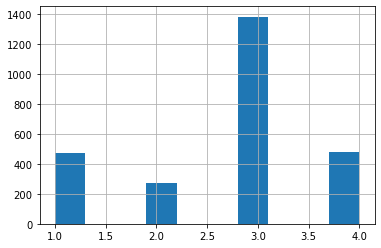

In [29]:
df.quadrant.hist()

In [30]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Simple RandomForest  (no normalization)

In [31]:
# Create DecisionTreeClassifier
clf = ensemble.RandomForestClassifier(max_depth=18, random_state=42)

# Fit the classifier to the data
clf.fit(X_train, y_train)

dump(clf, os.path.join(base_url_clf, 'baseline_maxdepth18_rs42.joblib'))

clf.score(X_test, y_test)

0.7796934865900383

## Normalizing the values 

In [32]:
X_normalized = MinMaxScaler().fit_transform(X)


X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_normalized, y, test_size=0.2, random_state=1, stratify=y)

In [33]:
clf = ensemble.RandomForestClassifier(max_depth=18, random_state=42)

# Fit the classifier to the normalized data
clf.fit(X_train_norm, y_train_norm)

dump(clf, os.path.join(base_url_clf, 'baseline_normalized_maxdepth18_rs42.joblib'))

clf.score(X_test_norm, y_test_norm)

0.7854406130268199

## Derive feature importance directly from the classifier

<AxesSubplot:xlabel='Available features', ylabel='Feature importance score'>

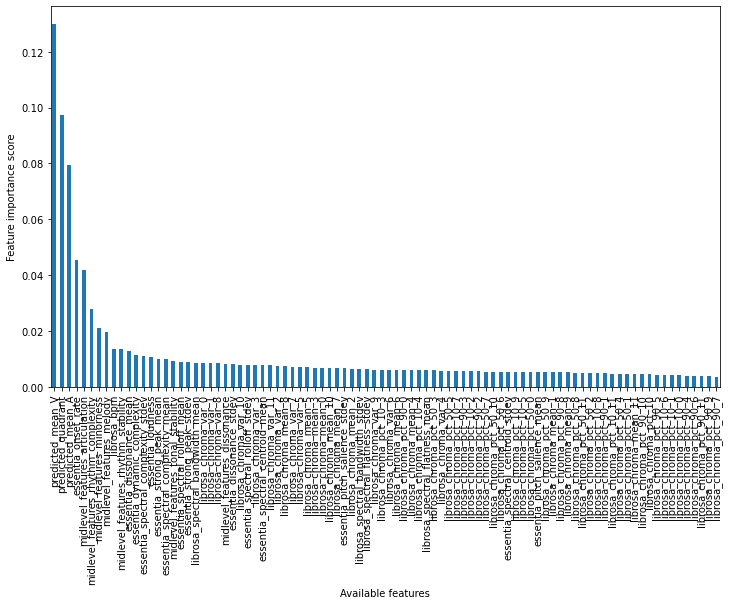

In [34]:
base_feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

base_feature_imp.plot(kind='bar', figsize=(12, 7), xlabel='Available features', ylabel='Feature importance score')

In [35]:
select_k_best = 15

In [36]:
### Unnormalized

In [37]:
# Drop every but the 15 most important features
X_best = X.drop(columns=[*base_feature_imp.index[select_k_best:]])

#split dataset into train and test data
X_train_best, X_test_best, y_train_best, y_test = train_test_split(X_best, y, test_size=0.2, random_state=1, stratify=y)

In [38]:
# Create DecisionTreeClassifier
clf = ensemble.RandomForestClassifier(max_depth=18, random_state=42)

# Fit the classifier to the selected features only
clf.fit(X_train_best, y_train_best)

dump(clf, os.path.join(base_url_clf, 'feature_selected_maxdepth18_rs42.joblib'))


clf.score(X_test_best, y_test)

0.7931034482758621

In [39]:
### Normalized

In [40]:
# Drop every but the 15 most important features [NORMALIZED]
X_best_norm = MinMaxScaler().fit_transform(X_best)

#split dataset into train and test data
X_train_best_norm, X_test_best_norm, y_train_best_norm, y_test_norm = train_test_split(X_best_norm, y, test_size=0.2, random_state=1, stratify=y)

In [41]:
# Create DecisionTreeClassifier
clf = ensemble.RandomForestClassifier(max_depth=18, random_state=42)

# Fit the classifier to the selected features only
clf.fit(X_train_best_norm, y_train_best_norm)

dump(clf, os.path.join(base_url_clf, 'feature_selected_normalized_maxdepth18_rs42.joblib'))

clf.score(X_test_best, y_test)

0.6494252873563219

<AxesSubplot:xlabel='Available features', ylabel='Feature importance score'>

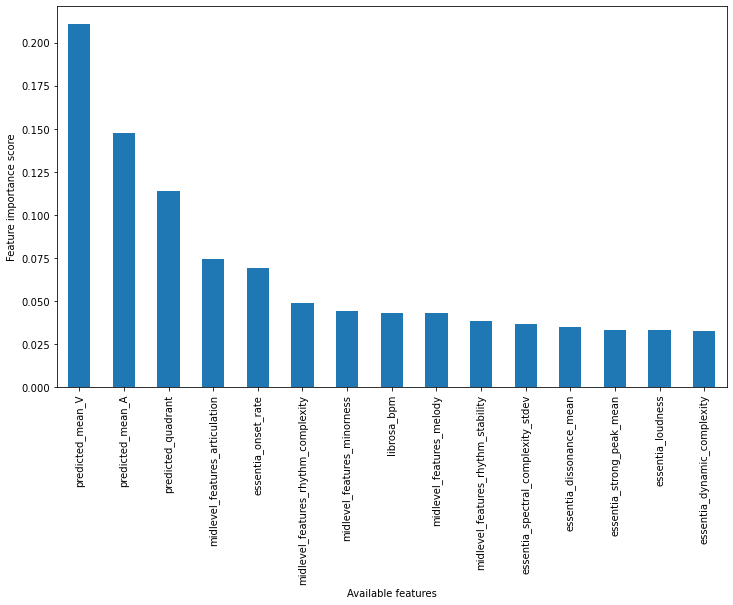

In [42]:
# Re-calculate feature importance 
feature_imp = pd.Series(clf.feature_importances_,index=X_best.columns).sort_values(ascending=False)

feature_imp.plot(kind='bar', figsize=(12, 7), xlabel='Available features', ylabel='Feature importance score')

# RandomForest with Cross-Validation

In [43]:
# These values that are chosen here come from trial-and-error
# We had decrease the size of the parameter space beforehand because otherwise gridsearch takes forever

param_grid = {'n_estimators': [20, 50, 100, 200, 500], # default is 100
               'max_depth' : [2, 4, 6, 10, 18, 25, 50], # default is None -> expanded until termination criteria is met
             }

In [44]:
## All features

In [45]:
gscv = GridSearchCV(clf, param_grid, cv=10, return_train_score=True, n_jobs=-1)

gscv.fit(X, y)

scores_all_features = gscv.cv_results_["mean_test_score"]

print("### all 87 features, no normalization ###")
print("best params: ", gscv.best_params_, "\nbest score: ",gscv.best_score_, "\n")

### all 87 features, no normalization ###
best params:  {'max_depth': 10, 'n_estimators': 200} 
best score:  0.771046271735927 



In [52]:
clf = ensemble.RandomForestClassifier(max_depth=10, n_estimators=200)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.7720306513409961

In [53]:
clf =  ensemble.RandomForestClassifier(max_depth=10, n_estimators=200)
clf.fit(X_train_best, y_train_best)

clf.score(X_test_best, y_test)

0.7854406130268199

In [48]:
### Only the k best features with k = 15

In [49]:
gscv_k_best = GridSearchCV(clf, param_grid, cv=10, return_train_score=True, n_jobs=-1)

gscv_k_best.fit(X_best, y)

scores_all_features = gscv_k_best.cv_results_["mean_test_score"]

print(f"### only the best {select_k_best} features, no normalization ###")
print("best params: ", gscv_k_best.best_params_, "\nbest score: ",gscv_k_best.best_score_, "\n")

### only the best 15 features, no normalization ###
best params:  {'max_depth': 6, 'n_estimators': 200} 
best score:  0.7775714706749188 



In [54]:
clf = ensemble.RandomForestClassifier(max_depth=6, n_estimators=200)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.7624521072796935

In [55]:
clf =  ensemble.RandomForestClassifier(max_depth=6, n_estimators=200)
clf.fit(X_train_best, y_train_best)

clf.score(X_test_best, y_test)

0.7720306513409961

### Best results from inital grid search above

#### Best score: 0.7911877394636015

In [70]:
best_params_found = {'max_depth': 10, 'n_estimators': 200, 'random_state': 42, 'criterion': 'entropy', 'max_features': 'log2', 'bootstrap': True}

In [71]:
clf = ensemble.RandomForestClassifier(**best_params_found)

In [63]:
refined_param_grid = {
                     'criterion': ['entropy', 'gini'],
                     'max_features': ['log2', 'sqrt'],
                     'bootstrap': [False, True]
                     }

In [64]:
gscv_refined = GridSearchCV(clf, refined_param_grid, cv=5, return_train_score=True, n_jobs=-1)

gscv_refined.fit(X_best, y)

scores_all_features = gscv_refined.cv_results_["mean_test_score"]

print(f"### only the best {select_k_best} features, no normalization ###")
print("best params: ", gscv_refined.best_params_, "\nbest score: ",gscv_refined.best_score_, "\n")

### only the best 15 features, no normalization ###
best params:  {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'log2'} 
best score:  0.7737125039527581 



In [76]:
clf.fit(X_train_best, y_train_best)

dump(clf, os.path.join(base_url_clf, 'best_maxdepth10_n-est200_rs42.joblib'))

clf.score(X_test_best, y_test)

0.7911877394636015

# Evaluation

In [66]:
def plot_search_results(grid, title="Score per parameter", log_list=[]):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle(title, fontsize=26)
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical', fontsize=18)
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper(), fontsize=18)
        if p in log_list: 
            ax[i].set_xscale('log')


    plt.legend()
    plt.show()

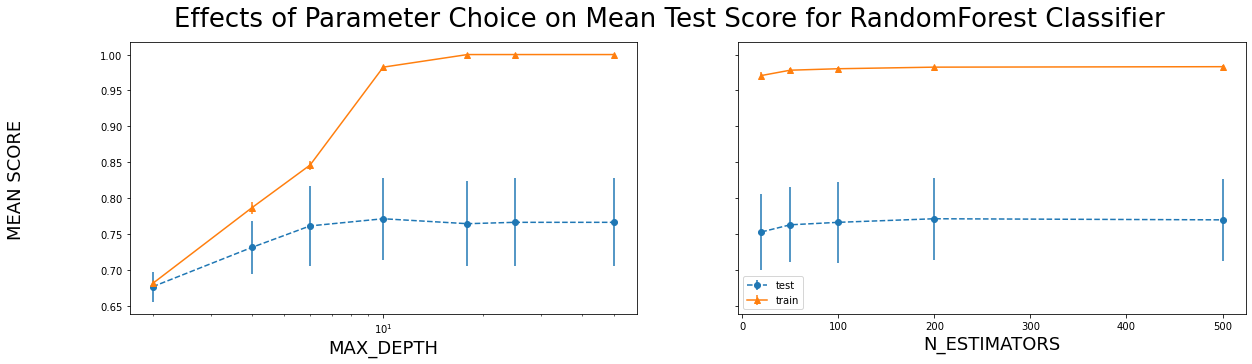

In [67]:
plot_search_results(gscv, title="Effects of Parameter Choice on Mean Test Score for RandomForest Classifier", log_list=["max_depth"])

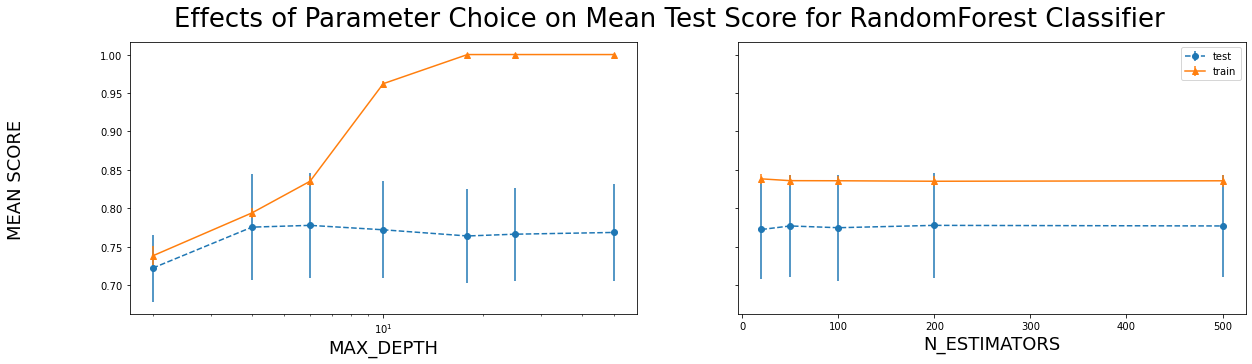

In [68]:
plot_search_results(gscv_k_best, title="Effects of Parameter Choice on Mean Test Score for RandomForest Classifier", log_list=["max_depth"])

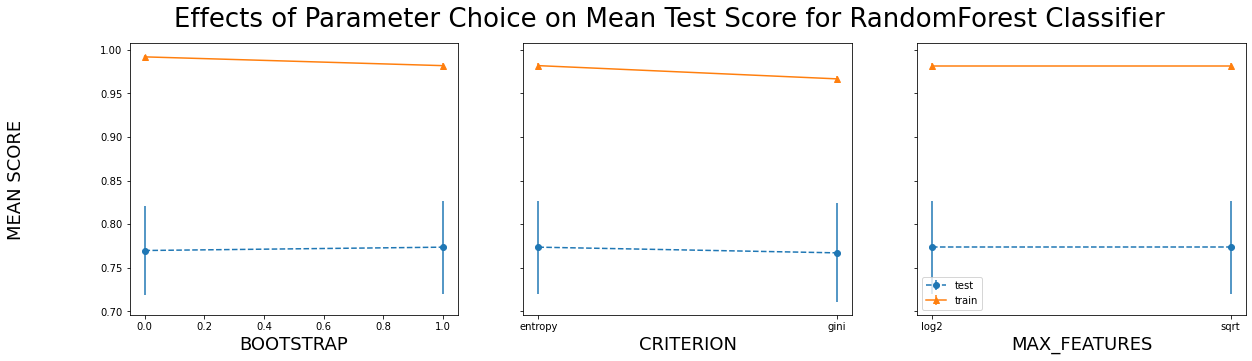

In [69]:
plot_search_results(gscv_refined, title="Effects of Parameter Choice on Mean Test Score for RandomForest Classifier", log_list=["max_depth"])

In [73]:
## Upgrading to our custom CV

In [85]:
# unfortunately I was not able to further improve the model

In [81]:
from GetCViterable import GetCViterable
cvIterable=GetCViterable().iterable("dataset/dataset_with_predicted_mean_A_mean_V.csv")

In [82]:
param_grid = {'n_estimators': [20, 50, 100, 200, 500], # default is 100
               'max_depth' : [2, 4, 6, 10, 18, 25, 50], # default is None -> expanded until termination criteria is met
             'criterion': ['entropy', 'gini'],
                     'max_features': ['log2', 'sqrt'],
                     'bootstrap': [False, True]
             }

gscv_k_best = GridSearchCV(clf, param_grid, cv=cvIterable, return_train_score=True, n_jobs=-1)

gscv_k_best.fit(X_best, y)

scores_all_features = gscv_k_best.cv_results_["mean_test_score"]

print(f"### only the best {select_k_best} features, no normalization ###")
print("best params: ", gscv_k_best.best_params_, "\nbest score: ",gscv_k_best.best_score_, "\n")

### only the best 15 features, no normalization ###
best params:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 18, 'max_features': 'log2', 'n_estimators': 20} 
best score:  1.0 



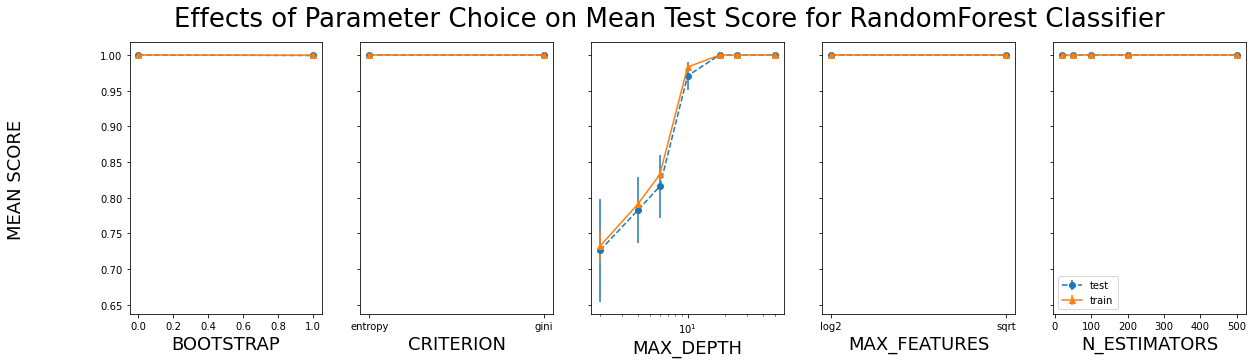

In [83]:
plot_search_results(gscv_k_best, title="Effects of Parameter Choice on Mean Test Score for RandomForest Classifier", log_list=["max_depth"])

In [84]:
clf = ensemble.RandomForestClassifier(max_depth=18, n_estimators=20, bootstrap=False, criterion='entropy', max_features='log2')
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.7796934865900383

In [91]:
clf_best = load(os.path.join(base_url_clf, 'best_maxdepth10_n-est200_rs42.joblib'))
clf_best.score(X_test_best, y_test)

0.7911877394636015

In [93]:
import time

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=1337, stratify=y)

# hier euren classifier mit best params verwenden:
clf_time = clf_best

train_times = []
predict_times = []

for i in range(100):

    start_time = time.time()
    clf_time.fit(X_train, y_train)
    train_times.append(time.time() - start_time)

    start_time = time.time()
    clf_time.predict(X_test)
    predict_times.append( (time.time() - start_time) )

print("Training Time:   \t", np.mean(train_times) * 1000, "ms" )
print("Prediction Time: \t", np.mean(predict_times) / len(y_test) * 1000, "ms")

Training Time:   	 2488.7663197517395 ms
Prediction Time: 	 0.0593041825568539 ms
